In [ ]:
#установка расширения
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 32.9MB/s 
     |████████████████████████████████| 51kB 9.8MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 194kB 60.2MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
Mounted at /content/gdrive


In [ ]:
# platform version e8ac39a4
import requests
import json
from typing import Union, Tuple
from pathlib import Path

class Client:
    def __init__(self, host, name, password, verify=False) -> None:
        '''
        Configure user credentials and remote host.
        '''
        self.host = host
        self.name = name
        self.password = password
        self.token = ''
        self.verify = verify
    def authorize(
                    self, 
                    version: str, 
                    dataset: str, 
                    subset: Union[bool, str] = False, 
                    roc_auc: float = 0.1, 
                    accuracy: float = 0.1, 
                    sensitivity: float = 0.1,
                    specificity: float = 0.1) -> Tuple[int, str]:
        '''
        Open a testing session and get session token. 
        The token lives for 24h.
        '''
        # convert from bool to string
        if isinstance(subset, bool):
            subset = "true" if subset else "false"
        message = {"service_name": self.name,
                "password": self.password,
                "version": version,
                "dataset": dataset, 
                "roc_auc": roc_auc, 
                "accuracy": accuracy, 
                "sensitivity": sensitivity, 
                "specificity": specificity, 
                "subset": subset}
        r = requests.post(
                            self.host + 'auth', 
                            json=message, 
                           verify=self.verify
                        )
        code = r.status_code
        text = json.loads(r.text)
        msg = text['message']
        token = text['session_token']
        self.token = token
        return code, msg

    def pull(self, dir_path: Union[str, Path] = 'data') -> Tuple[str, int, str]:
        '''
        Pull a study from the server and save it.
        dir_path is a path to the directory with current file.
        The filename is its study_uid.
        Returns received study_uid, response code and response message.
        '''
        message = {'service_name': self.name,
                'session_token': self.token}
        r = requests.post(
                            self.host + 'pull', 
                            json=message, 
                            verify=self.verify
                        )
        code = r.status_code
        # hack to handle error displacement
        if code == 200:
            msg = r.headers["message"]
        else:
            text = json.loads(r.text)
            msg = text['message']
            return ['', code, msg]
        uid = r.headers['study_uid']
        if isinstance(dir_path, str):
            dir_path = Path(dir_path)
            if not dir_path.is_dir():
                Path(dir_path).mkdir(parents=True, exist_ok=True)
        data = r.content
        dir_path = dir_path / (uid+'.zip')
        with dir_path.open('wb') as s:
            s.write(data)
        return uid, code, msg


    def push(self, study_uid: str, val: float) -> Tuple[int, str]:
        '''
        Send the prediction value to the server.
        Returns response code and response message.
        '''
        message = {
                'service_name': self.name,
                'session_token': self.token,
                'study_uid': study_uid,
                'abnormality_probability': val
                }
        r = requests.post(
                            self.host + 'push', 
                            json=message,
                            verify=self.verify
                        )
        try:
            text = json.loads(r.text)
            msg = text['message']
        except Exception as e:
            msg = None
        code = r.status_code
        return code, msg

    def report(self, rep_path=base_dir)  -> Tuple[int, str]:
        '''
        Get the model quality report based on predictions and saves it as .pdf file.
        Is not properly tested due to problems with server.
        rep_path is a path to the current file, including its name ('report by default')
        Returns response code and response message.
        '''
        message = {'service_name': self.name,
                'password': self.password,
                'session_token': self.token}
        r = requests.post(
                            self.host + 'report', 
                            json=message,
                            verify=self.verify
                        )
        data = r.content
        code = r.status_code
        if code == 200:
            msg = r.headers["message"]
        else:
            text = json.loads(r.text)
            msg = text['message']
            return code, msg
        if isinstance(rep_path, str):
            rep_path = Path(rep_path)
            rep_path = rep_path.with_suffix('.pdf')
        with rep_path.open('wb') as s:
            s.write(data)
        return code, msg

In [ ]:
!pip install pypng

     |████████████████████████████████| 655kB 6.4MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67179 sha256=4da441de9f172f3b765d8f1bfa1a8178d2acbe2ed5c8aaa8ecedda25960a42c9
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.3MB/s 


In [ ]:
import zipfile
import tqdm
import shutil
import pydicom
from pathlib import Path
from PIL import Image
import cv2
import png

In [ ]:
def unzip(zip_filename: str, dst_dir):
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        zf.extractall(dst_dir)

def is_valid(ds):
    a = False
    try:
         a = ds[0x0018, 0x1400].value in ['ГРУДНАЯ КЛЕТКА, Пр стоя', 'ГРУДНАЯ КЛЕТКА, ПЕРЕДНЯЯ P->A','postero-anterior^Factory1']
    except:
        pass
    try:
         a =  ds[0x0018, 0x5101].value in ['AP']
    except:
        pass
    try:
         a = ds[0x0054,0x0220][0][0x0008, 0x0104].value in ['postero-anterior']
    except:
        pass
    return a

In [ ]:
client = Client(host='https://test.ai-testing.tele-med.ai/',name='lion-ai',password='lion')

In [ ]:
print(client.authorize(dataset='RG_pneumonia_students', subset=True, version='1.0.3', roc_auc=0.4, accuracy=0.8, sensitivity=0.9, specificity=0.7))

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


(200, 'INFO: Testing session has already been opened')


In [ ]:
pull_data = client.pull(base_dir)
pull_data

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


('1.2.643.5.1.13.13.12.2.77.8252.04130013130814120806130312100615',
 200,
 'SUCCESS: OK')

In [ ]:
pull_data

['',
 403,
 'ERROR: Session is in pending state: dataset is in process. Please, try again later']

In [ ]:
#запрашиваю данные и записываю ответ в переменную pull_data
pull_data = client.pull(base_dir)
#разархивирую присланный архив
unzip(base_dir+'/'+pull_data[0]+'.zip', dst_dir=base_dir+'/'+pull_data[0])
#удаляю архив
os.remove(base_dir+'/'+pull_data[0]+'.zip')
data_dir = base_dir+'/'+pull_data[0]+'/'
#прохожу циклами по всем вложенным папкам и ищу файлы с окончанием .dcm
for folder in os.listdir(data_dir):
    for item in os.listdir(data_dir+folder):
        if item.endswith('.dcm'):
          #читаю dicom
            ds = pydicom.dcmread(data_dir+folder+'/'+item)
            #проверяю на валидность(уже не нужно)
            is_val = is_valid(ds)
            print(is_val,'/////')
            #извлекаю и вывожу изображение если оно там есть вместе с названием файла
            try:
                arr = ds.pixel_array
                plt.imshow(arr, cmap='gray')
                plt.show()
                print(folder+'/'+item)
            except:
                print('нет изображения')

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


FileNotFoundError: ignored

In [ ]:
ds = pydicom.dcmread(base_dir+'/'+pull_data[0]+'/1.2.643.5.1.13.13.12.2.77.8252.03090410081315140815081014090611/1.2.643.5.1.13.13.12.2.77.8252.06050401050715020307021111000114.dcm')
shape = ds.pixel_array.shape
# Convert to float to avoid overflow or underflow losses.
image_2d = ds.pixel_array.astype(float)
# Rescaling grey scale between 0-255
image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
# Convert to uint
image_2d_scaled = np.uint8(image_2d_scaled)
# Write the PNG file
with open(base_dir+'/'+pull_data[0]+'/'+'file.jpeg', 'wb') as png_file:
    w = png.Writer(shape[1], shape[0], greyscale=True)
    w.write(png_file, image_2d_scaled)

a = list(learn_testing.predict(base_dir+'/'+pull_data[0]+'/'+'file.jpeg')[2])[1]
res = float(re.findall(r'[0123456789.]+', str(a))[0])
if res>0.2:
  res = res+0.5
if res >= 1:
  res = 0.99
print(a, res)

tensor(0.0155) 0.0155


In [ ]:
client.push(study_uid=pull_data[0], val=res)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


(200, 'SUCCESS: OK. Testing session has been successfully finished')

In [ ]:
import time
for i in range(100000):
  print(i)
  time.sleep(50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [ ]:
shutil.rmtree(base_dir+'/'+pull_data[0])

In [ ]:
client.report(rep_path=base_dir)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


(403, 'ERROR: Report is in process. Please, try again later')

In [ ]:
client.report('/content/gdrive/My Drive/Colab Notebooks/fastai_image_data_loader')

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


(200, 'SUCCESS: OK')

In [ ]:
#настройка окружения
from fastai.imports import *
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/fastai_image_data_loader'
path = Path(base_dir)
dest = path/"folder"
dest.mkdir(parents=True, exist_ok=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Mounted at /content/gdrive


In [ ]:
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate, accuracy
from fastai.vision import learner
from fastai.vision import models

In [ ]:
from fastai.vision.augment import Resize

In [ ]:
#подготовка данных
data = ImageDataLoaders.from_csv(path=base_dir, folder='train10', csv_fname='stage_2_train_labels_5.csv',valid_pct=0.2, bs=64, suff='.jpg',fn_col='patientId',label_col='Target',item_tfms=Resize(224))

In [ ]:
import pandas as pd
df[df['patientId']=='010ccb9f-6d46-4380-af11-84f87397a1b8'].Target[0]

In [ ]:
df[df['patientId']=='010ccb9f-6d46-4380-af11-84f87397a1b8'].Target.array[0]

1

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fastai_full/stage_2_train_labels.csv')
df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


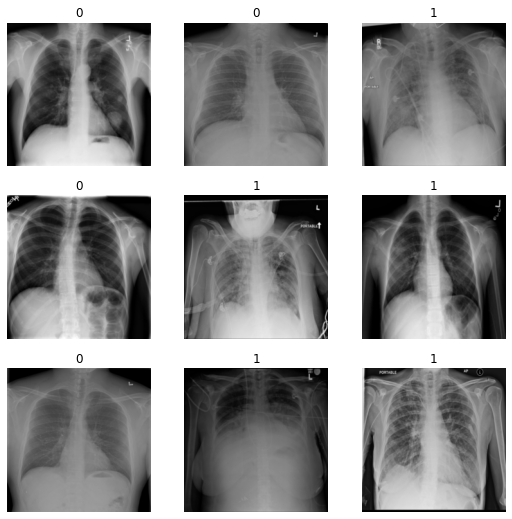

In [ ]:
data.show_batch()


In [ ]:
#создание объекта learner
learn = learner.cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#обучение в 4 эпохи
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.598772,0.459774,0.802316,1:31:05
1,0.428805,0.402140,0.815881,05:57
2,0.380020,0.388586,0.821671,05:57
3,0.349997,0.387620,0.822498,05:57
4,0.317069,0.385718,0.826799,05:56


In [ ]:
#сохраняю модель
learn.save(base_dir+'3GBsamples0826accuracy')

Path('/content/gdrive/My Drive/Colab Notebooks/fastai_full3GBsamples0826accuracy.pth')

In [ ]:
learn = learner.load_learner(base_dir+'3GBsamples0826accuracy')

In [ ]:
#загружаю сохраненную модель
learn_testing = learner.load_learner('/content/gdrive/My Drive/Colab Notebooks/fastai_full3GBsamples0826accuracy')

TypeError: ignored

In [ ]:
import re

In [ ]:
pred_values

[0.4273,
 0.0167,
 0.1839,
 0.0013,
 0.1168,
 0.0106,
 0.0299,
 0.009,
 0.8974,
 0.0446,
 0.09]

In [ ]:
y_valids = []
preds_binary = []
pred_values = []
i=0
for item in os.listdir('/content/gdrive/My Drive/Colab Notebooks/fastai_image_data_loader/train10/'):
  y_valid = int(df[df['patientId']==item[:-4]].Target.array[0])
  print('valid=',y_valid)
  y_valids.append(y_valid)
  a = learn_testing.predict('/content/gdrive/My Drive/Colab Notebooks/fastai_image_data_loader/train10/'+item)
  pred_binary = int(a[0])
  preds_binary.append(pred_binary)
  print('pred_binary=',pred_binary)
  b = list(a[2])[1]
  pred_value = float(re.findall(r'[0123456789.]+', str(b))[0])
  pred_values.append(pred_value)
  print('pred_value=',pred_value)
  print('-------------------------')
  i+=1
  if i > 300:
    break

valid= 1


pred_binary= 0
pred_value= 0.4273
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0167
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1839
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0013
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1168
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0106
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0299
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.009
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8974
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0446
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.09
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0184
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7246
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.627
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0004
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.933
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4575
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0401
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5515
-------------------------
valid= 0


pred_binary= 1
pred_value= 0.5471
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0352
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4037
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.4739
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0592
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0372
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0682
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4143
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8319
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0016
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.4372
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0125
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0088
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5744
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0072
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4493
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0036
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0394
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0019
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0889
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3532
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0062
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7125
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3529
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0019
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0042
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5921
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.1197
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0095
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.005
-------------------------
valid= 0


pred_binary= 1
pred_value= 0.5182
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.088
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.516
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.037
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4852
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4069
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5656
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8694
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5466
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0636
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0658
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3037
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9361
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0302
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4346
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0365
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0111
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0018
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0121
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.1856
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0013
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6985
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0057
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9656
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0163
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9834
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0499
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8235
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0033
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.663
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0586
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5781
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4494
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0028
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4927
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0019
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0355
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0332
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7069
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0036
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8022
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9186
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.001
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0045
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0694
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9694
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0198
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9614
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0127
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8829
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1232
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0506
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0038
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8644
-------------------------
valid= 0


pred_binary= 1
pred_value= 0.5014
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6825
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0598
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0364
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0026
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0022
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.324
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0012
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.248
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.0254
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0168
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0015
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0198
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.004
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0048
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0141
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.1745
-------------------------
valid= 0


pred_binary= 0
pred_value= 8.3073
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8866
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8238
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1907
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7639
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.043
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.123
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.282
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0007
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0486
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0874
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8442
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0233
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.004
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3582
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.0899
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0451
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.4431
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6196
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.002
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4538
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9791
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.3524
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9255
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0017
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9278
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.2631
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1902
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0123
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0169
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.2371
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0179
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.04
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0236
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.2999
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0178
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3533
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0132
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0064
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0162
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.0911
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0848
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.011
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0228
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.2073
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0172
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6556
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8365
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4069
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9006
-------------------------
valid= 0


pred_binary= 1
pred_value= 0.7278
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.1671
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0066
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0173
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9132
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0378
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5688
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7242
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.3655
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0374
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8972
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0109
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9088
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0667
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0016
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0195
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0035
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.01
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0088
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.007
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0343
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.1605
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0637
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0146
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0037
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8978
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0073
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0303
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6052
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.002
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0021
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0112
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0027
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6842
-------------------------
valid= 0


pred_binary= 1
pred_value= 0.6064
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0024
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.2638
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0348
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0112
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5926
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0361
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0225
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0057
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1643
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.957
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9157
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0345
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4785
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0025
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5206
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9535
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0646
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6326
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8341
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0033
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0189
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0425
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0067
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.749
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.328
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6676
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.0123
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0067
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0082
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0117
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.4386
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5569
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0578
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1381
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1839
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0006
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5343
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.2359
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0965
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0092
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.006
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0276
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9185
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0352
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0119
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.473
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0118
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5448
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1319
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1469
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.7063
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0021
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.8298
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6995
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6495
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0272
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0185
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3942
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.002
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.9683
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0033
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0112
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.1518
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0578
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0339
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.2223
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.2953
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0095
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0708
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0094
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0073
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0113
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6194
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6453
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0014
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0374
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.6672
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0283
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0058
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.4017
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.5096
-------------------------
valid= 1


pred_binary= 1
pred_value= 0.909
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0049
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0153
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.2034
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0043
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0025
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0342
-------------------------
valid= 1


pred_binary= 0
pred_value= 0.3617
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0157
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.007
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0041
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0114
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0224
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.0043
-------------------------
valid= 0


pred_binary= 0
pred_value= 0.055
-------------------------


In [ ]:
import numpy as np
y_valids = np.array(y_valids)
preds_binary = np.array(preds_binary)
pred_values = np.array(pred_values)

In [ ]:
import numpy as np

In [ ]:
with open(base_dir+'/y_valids.pickle', 'rb') as f:
  y_valids=pickle.load(f)

with open(base_dir+'/preds_binary.pickle', 'rb') as f:
  preds_binary=pickle.load(f)

with open(base_dir+'/pred_values.pickle', 'rb') as f:
  pred_values=pickle.load(f)



In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.rcParams["figure.figsize"] = (8,6)

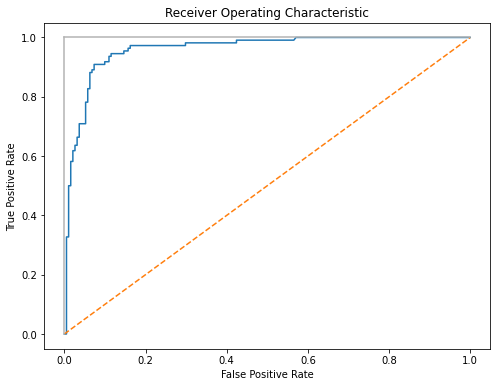

In [ ]:
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_valids,
                                                               pred_values)
# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valids,
                            preds_binary))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       191
           1       0.93      0.64      0.76       110

    accuracy                           0.85       301
   macro avg       0.88      0.81      0.82       301
weighted avg       0.86      0.85      0.84       301



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valids, preds_binary)

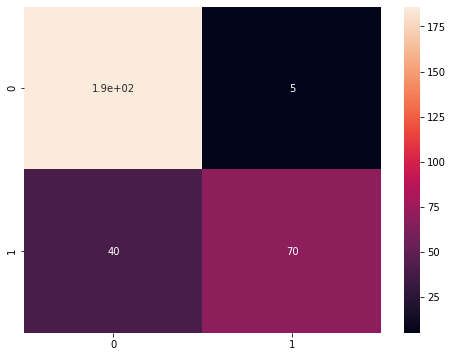

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=cm)

In [ ]:
#делаем предикт
i=0
for item in os.listdir('/content/gdrive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/'):
  print(df[df['patientId']==item[:-4]].Target.array[0])
  a = list(learn_testing.predict('/content/gdrive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/'+item)[2])[1]
  i+=1
  res = float(re.findall(r'[0123456789.]+', str(a))[0])
  if res>0.2:
    res = res+0.5
    if res >= 1:
      res = 0.99
  print(res)
  if i>50:
    break

IndexError: ignored

In [ ]:
res

0.9768

In [ ]:
summa=0
i=0
for item in os.listdir(base_dir+'/chest_xray/PNEUMONIA'):
    summa+=int(learn.predict(base_dir+'/chest_xray/PNEUMONIA/'+item)[0])
    i+=1
print(summa/i)

0.20930232558139536
